Date created: July 13, 2022

---


## Project 2: Flow Over a Flat Plate
**Contributors:** Mason Friedberg, Brian Tan, Tyler Reiser      
**Summary:** Modeling the flow over a flat plate.  
       
---
#### Physics
We have a flat plate sitting somewhere in space. The flat plate has a uniform temperature, so the the temperature at all points on the plate are equal, and the plate is stationary. In the space around the flat plate, there is a fluid with a uniform temperature, so the temperature of the fluid at any point is equal, and the fluid is moving since the horizontal velocity is greater than zero.

Let the fluid move uniformly towards the flat plate from left-to-right. Then there is some point where the fluid meets the leading edge of the plate and the temperature of the plate and fluid diffuse in some way, for example,
    1. The fluid loses heat to the plate   
    2. The plate loses heat to the fluid   
    3. The temperature of the plate and fluid remain constant   
We will focus on the first two cases and make the assumption that the plate is only losing heat from the top. Whether case one or two happens, the fluid will continue to cover more of the plate over time. overs the least amount of the plate and there is some point where the fluid covers all of the plate. Between these two points, we have two changes occuring:


1. Velocity   
The plate is not moving, so we do not have to consider that. The fluid is moving, and as it flows over the plate, the velocity of the 
   
2. Temperature 
    - of the fluid
    - of the plate

#### Finding the coupled system
The goal is to represent a higher-order differential equation as a coupled, ordinary differential equation. 

fWe want $G$, but we need to know $F$ to solve for $G$. So there are two equations. Writing it as a system is a little more difficult, so let's split it up. 

$F$ is a third-order differential equation with three given boundary conditions. So this is a **three-point boundary valued problem**. These are really tough to solve, unless we can turn it into an initial value problem. We can solve IVP easily with RK4. Look at [1] for reference on how to transform the higher-order differential equation as a coupled system of first-order differential equations. This is one of the algorithms learned in differential equations.

Let the coupled system of first order differential equations be,
$$ y_1' = y_2, y_2' = y_3, y_3' = - \frac{1}{2} y_1 y_3 $$
and let the initial conditions be,   
$$y_1(0) = F(0) = 0, y_2(0) = F'(0) = 0, y_3(0) = F''(0) = u $$

Note that we are making a guess at the initial conditions here. Since the success of the algorithm relies on this guess, we need to "do our homework" on the problem and make sure this is an educated guess. This is the analysis of the numerics. 

Now, consider the boundary-values given by the problem. Notice that one point is at infinity; this implies that the first two boundary-values are very close to eachother when compared to their distance from the point at infinity. Because of this, I think it's best to integrate from left-to-right. The step size is given to us as $0.1$.
        
---

#### Fourth-order Runge Kutta Method
Adding more equations (ie. a system of equations vs one) to the RK4 algorithm doesn't change the code from project 1 too much. It looks big and confusing but it just has more variables. Note that this is written without loops to avoid type-checks. The algorithm is in one function that moves our initial guesses across time. Since we have a system of differential equations, at each step, we have to move each initial condition across time for every equation and RK4 tells us how we "average" the results of each output. The output is the coordinates of our initial conditions at the next step in time.

In [1]:
import numpy as np
import random

def RK4(t,y1,y2,y3,dt):
    def equation_1(t,y1,y2,y3):
        return y2
    def equation_2(t,y1,y2,y3):
        return y3
    def equation_3(t,y1,y2,y3):
        return (-1/2)*(y1*y3)
    
    k1 = np.array([0.,0.,0.])
    k2 = np.array([0.,0.,0.])
    k3 = np.array([0.,0.,0.])
    k4 = np.array([0.,0.,0.])

    k1[0] = dt*equation_1(t, y1, y2, y3)
    k1[1] = dt*equation_2(t, y1, y2, y3)
    k1[2] = dt*equation_3(t, y1, y2, y3)

    k2[0] = dt*equation_1(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2.)
    k2[1] = dt*equation_2(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2.)
    k2[2] = dt*equation_3(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2.)

    k3[0] = dt*equation_1(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2.)
    k3[1] = dt*equation_2(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2.)
    k3[2] = dt*equation_3(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2.)

    k4[0] = dt*equation_1(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2])
    k4[1] = dt*equation_2(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2])
    k4[2] = dt*equation_3(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2])

    y1 = y1 + (1./6.)*(k1[0] + 2.*k2[0] + 2.*k3[0] + k4[0])
    y2 = y2 + (1./6.)*(k1[1] + 2.*k2[1] + 2.*k3[1] + k4[1])
    y3 = y3 + (1./6.)*(k1[2] + 2.*k2[2] + 2.*k3[2] + k4[2])
    
    return np.array([y1, y2, y3])

---
### Shooting Method
The idea behing the *shooting method* is to check how well our guesses are by calculating the *boundary residual*. To do this, we compute the difference between the computed and given boundary values at a point. 

ie.   
actual boundary-values $ = U_R = [x, y, z]$   
guessed boundary-values $ = U = [x_0, y_0, z_0]$   
$res(U) = \theta(U) - U_R = 0 $ 

which is a **root-finding problem**, as long as the given boundary values straddle the root. For many reasons, *newton's method* is awesome, but to avoid finding the derivative, we can use **bisection method**. 

But, let's think about **what we actually doing:**   
We are creating boxes with the size of our maximum time value. Within the box, we are defining a coordinate system based for a dynamical system and approximating the location of the system at x, y, z at a bunch of equally spaced times. These locations within the box are called *nodes*. Since we made a guess at the initial values, we are calculating a the residual at each one of these nodes to see the difference, then using that value to perform another interation. As long as our guess is "good," each iteration gets us a better approximation of the solution.

#### Velocity
Here we calculate the velocity using the shooting method.

In [2]:
def guess_to_residual(u,RK4):
    t0 = 0.1
    dt = 0.1
    tmax = 10.1
    vector_t = np.arange(t0,tmax,dt)
    n = len(vector_t)
    
    rk4_velocity_data = np.zeros((n,3))
    rk4_velocity_data[0,0] = 0
    rk4_velocity_data[0,1] = 0
    rk4_velocity_data[0,2] = u
    for i in range(n-1): 
        rk4_velocity_data[i+1,:] = RK4(vector_t[i], rk4_velocity_data[i,0], rk4_velocity_data[i,1], rk4_velocity_data[i,2], dt)
        
    y = rk4_velocity_data[len(rk4_velocity_data)-1]
    r = y[1] - 1
    return r
print("Here is the value of $F'$: ", guess_to_residual(.5,RK4))

Here is the value of $F'$:  0.3137254218503429


---
#### Root-finding

Now we use a root finding method to iteratively find the best value for F'

<IPython.core.display.Javascript object>


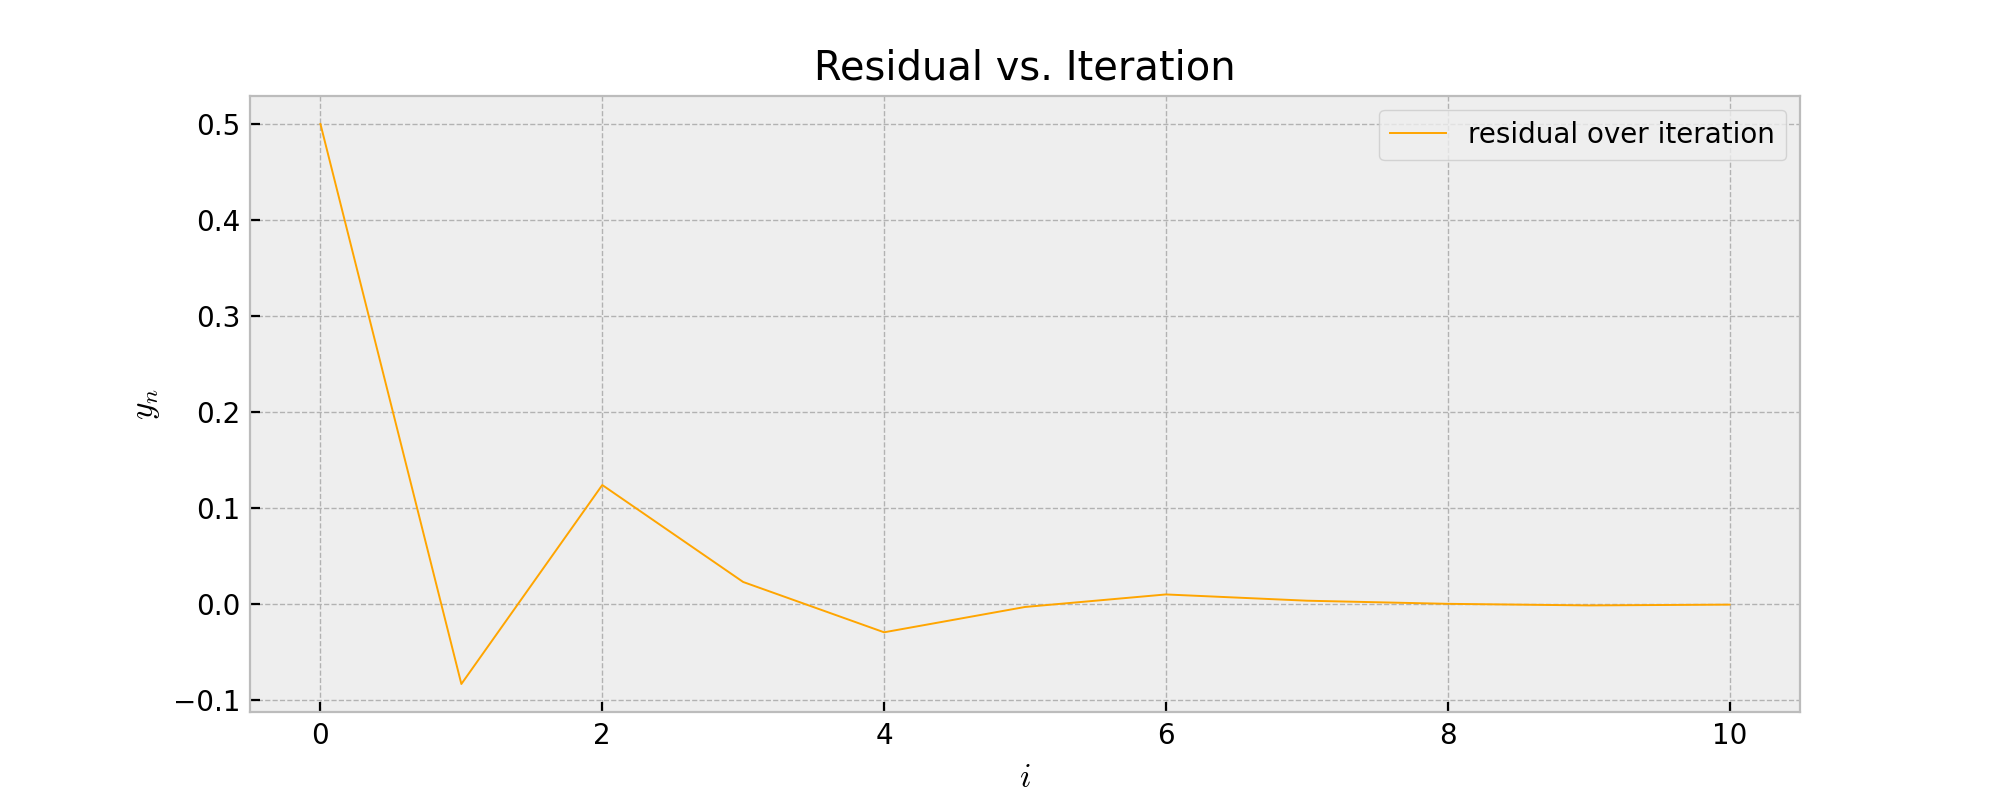

this is the final value for y3:  0.3320573461317736


In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('bmh')

def bisect(u0,guess_to_residual,RK4):
    iteration = []; residual = []
    r1 = 0; r1g = 0
    itt = 0
    r0 = guess_to_residual(u0,RK4)
    if r0 > 0:
        while r1 >= 0 and r1g < 1000:
            u1 = 1/random.randint(1,1000)
            r1 = guess_to_residual(u1,RK4)
            r1g += 1
    elif r0 < 0:
        while r1 <= 0 and r1g < 1000:
            u1 = 1/random.randint(1,1000)
            r1 = guess_to_residual(u1,RK4)
            r1g += 1
        ll,gg = r0,u0
        r0,u0 = r1,u1
        r1,u1 = ll,gg   
    r = 0.5
    residual.append(r)
    iteration.append(int(itt))
    while abs(r) > 10**(-15) and itt < 1000:
        unew = (u1+u0)/2
        r = guess_to_residual(unew,RK4)
        residual.append(r)
        if r < 0:
            u1 = unew
        elif r >= 0:
            u0 = unew
        itt += 1
        iteration.append(int(itt))
    return [iteration, residual, unew]

def plot_residual_F(eta,bisect):
    x,y,y3 = bisect(0.5,guess_to_residual,RK4)
    x_plot = np.arange((len(x)+1)/5)
    n = len(x_plot)
    
    plt.figure(figsize=(10,4))
    plt.title('Residual vs. Iteration')
    plt.ylabel('$y_n$')
    plt.xlabel('$i$')
    plt.plot(x_plot, y[:n], color='orange', label="residual over iteration", linewidth='0.7')
    plt.legend()
    plt.show()
    return print("this is the final value for y3: ", y3)

plot_residual_F(0,bisect)

---
#### Plotting a data stream
We are modeling a dynamical system over time, so these values represent something happening in in real life.

The following are multiple plots of our values, namely [𝑥,𝑦,𝑧], as they move across time. First, three time-series plots to show 𝑥, 𝑦, and 𝑧 as they move across time. Now that we got the best possible value for z, we can solve the initial value problem one more time to record the results. The time-scale is defined above. We want to move the initial conditions across time, so a single loop is used, this is an **iterative method**.

<IPython.core.display.Javascript object>


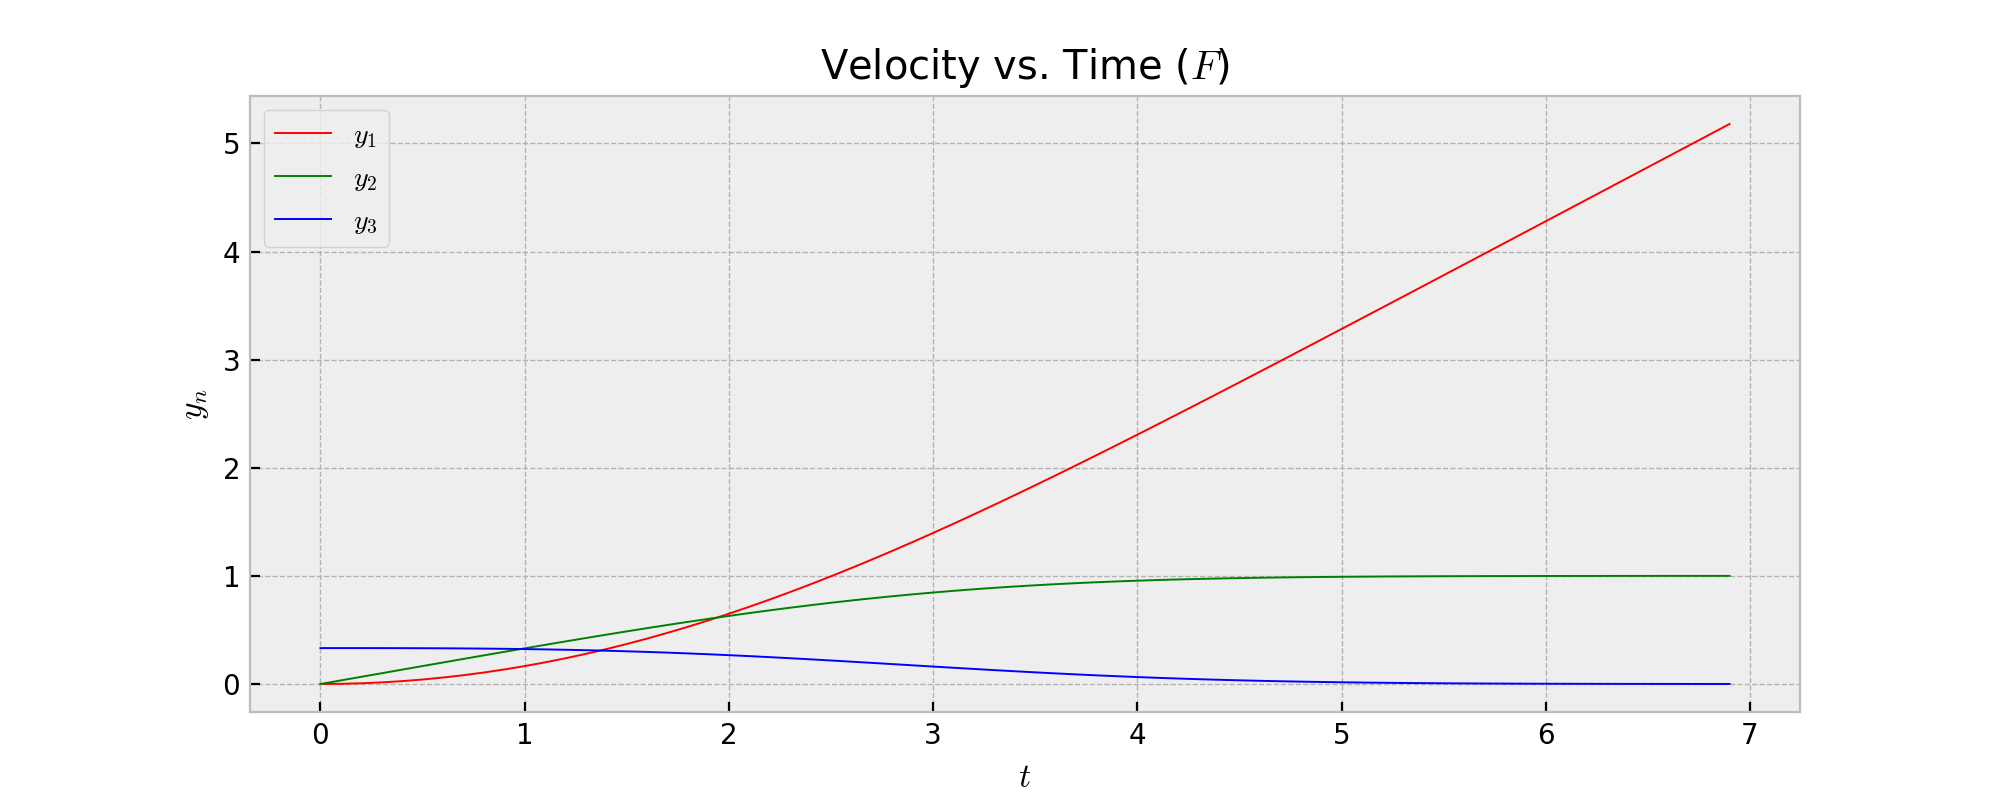

In [4]:
y1 = 0
y2 = 0
y3 = bisect(0.5,guess_to_residual,RK4)[2]
eta = 5.5

t0 = 0
dt = 0.1
tmax = 10
vector_t = np.arange(t0,tmax,dt)
n = len(vector_t)

rk4_velocity_data = np.zeros((n,3))
rk4_velocity_data[0,0] = y1
rk4_velocity_data[0,1] = y2
rk4_velocity_data[0,2] = y3
for i in range(n-1): 
    rk4_velocity_data[i+1,:] = RK4(vector_t[i], rk4_velocity_data[i,0], rk4_velocity_data[i,1], rk4_velocity_data[i,2], dt)

plt.figure(figsize=(10,4))
plt.title("Velocity vs. Time ($F$)")
plt.ylabel('$y_n$')
plt.xlabel('$t$')
plt.plot(vector_t[:int(n*(0.7))], rk4_velocity_data[:int(n*(0.7)),0], color='r', label="$y_1$", linewidth='0.7')
plt.plot(vector_t[:int(n*(0.7))], rk4_velocity_data[:int(n*(0.7)),1], color='g', label="$y_2$", linewidth='0.7')
plt.plot(vector_t[:int(n*(0.7))], rk4_velocity_data[:int(n*(0.7)),2], color='b', label="$y_3$", linewidth='0.7')
plt.legend()
plt.show()

---
#### Coupled Data
Here we find the velocity and temperature by solving the coupled system of equations.

Let the coupled system of first order differential equations be,
$$ y_1' = y_2, y_2' = y_3, y_3' = - \frac{1}{2} y_1 y_3 $$
and let the initial conditions be,   
$$ y_1(0) = F(0) = 0, y_2(0) = F'(0) = 0, $$ 
and    
$$ y_3(0) = F''(0) = u $$

Note that we are making a guess at the initial conditions here. Since the success of the algorithm relies on this guess, we need to "do our homework" on the problem and make sure this is an educated guess. This is the analysis of the numerics. 


<IPython.core.display.Javascript object>


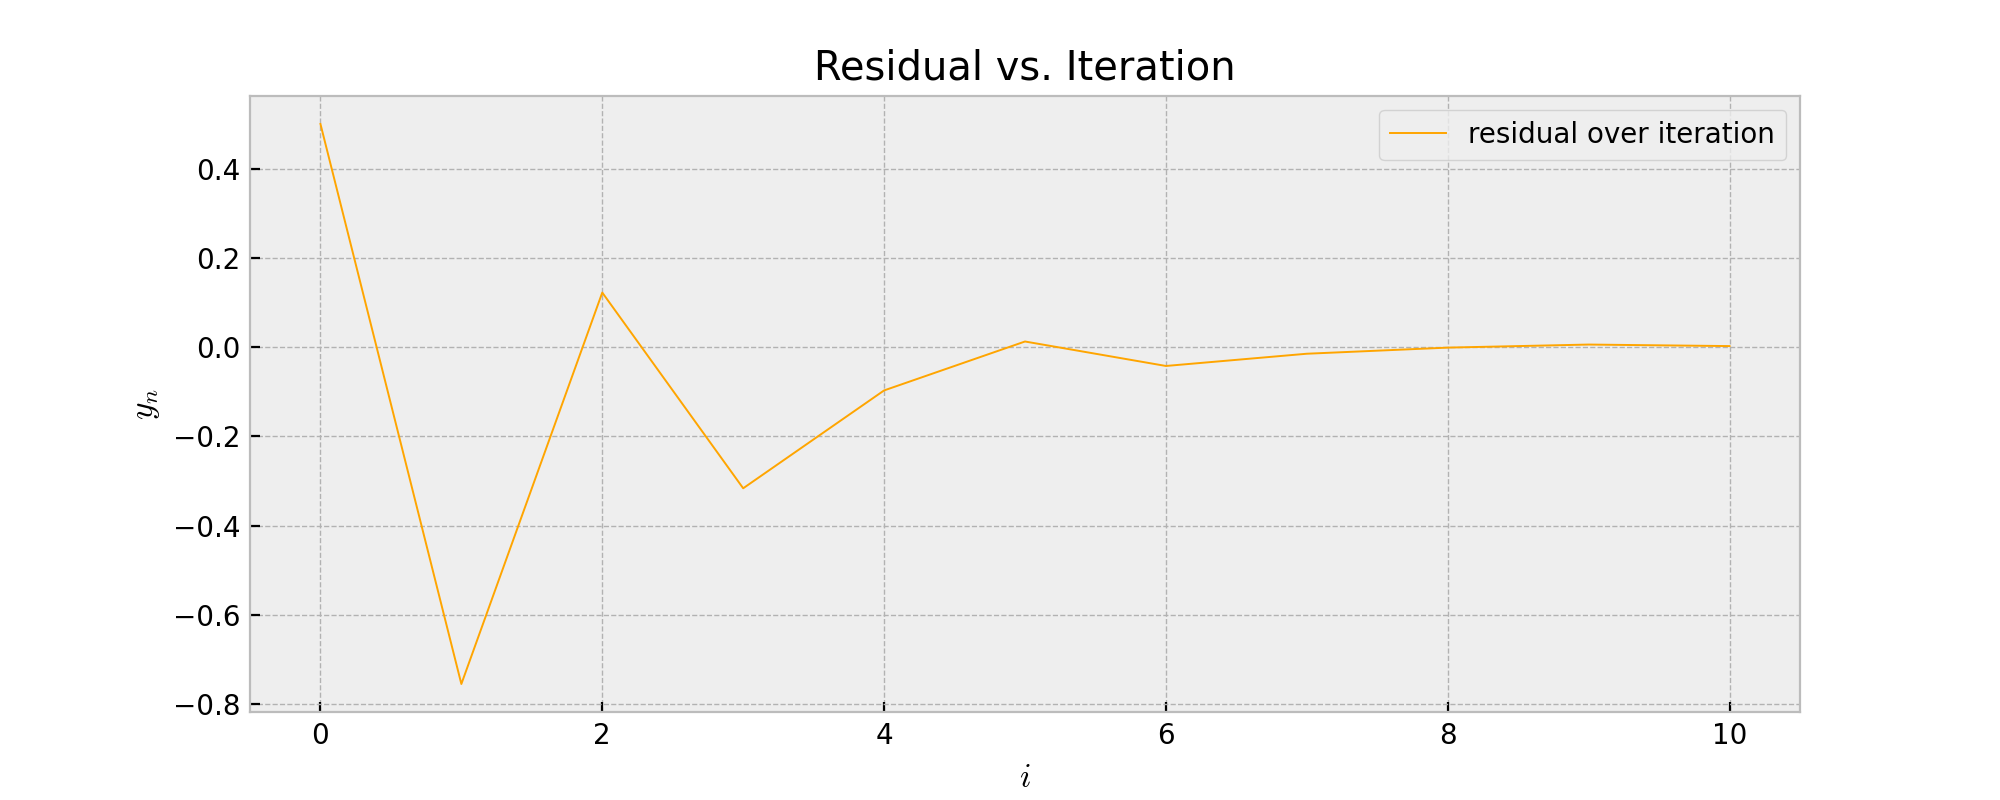

Best value for $y_5$:  -0.5687037663054155


In [5]:
def RK4_temp(t,y1,y2,y3,y4,y5,dt,pr=5):
    def equation_1(t,y1,y2,y3,y4,y5):
        return y2
    def equation_2(t,y1,y2,y3,y4,y5):
        return y3
    def equation_3(t,y1,y2,y3,y4,y5):
        return (-1/2)*(y1*y3)
    def equation_4(t,y1,y2,y3,y4,y5):
        return y5
    def equation_5(t,y1,y2,y3,y4,y5):
        return (-1/2)*pr*(y1*y5)
    
    k1 = np.array([0., 0., 0., 0., 0.])
    k2 = np.array([0., 0., 0., 0., 0.])
    k3 = np.array([0., 0., 0., 0., 0.])
    k4 = np.array([0., 0., 0., 0., 0.])

    k1[0] = dt*equation_1(t, y1, y2, y3, y4, y5)
    k1[1] = dt*equation_2(t, y1, y2, y3, y4, y5)
    k1[2] = dt*equation_3(t, y1, y2, y3, y4, y5)
    k1[3] = dt*equation_4(t, y1, y2, y3, y4, y5)
    k1[4] = dt*equation_5(t, y1, y2, y3, y4, y5)

    k2[0] = dt*equation_1(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)
    k2[1] = dt*equation_2(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)
    k2[2] = dt*equation_3(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)
    k2[3] = dt*equation_4(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)
    k2[4] = dt*equation_5(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)

    k3[0] = dt*equation_1(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)
    k3[1] = dt*equation_2(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)
    k3[2] = dt*equation_3(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)
    k3[3] = dt*equation_4(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)
    k3[4] = dt*equation_5(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)

    k4[0] = dt*equation_1(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])
    k4[1] = dt*equation_2(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])
    k4[2] = dt*equation_3(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])
    k4[3] = dt*equation_4(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])
    k4[4] = dt*equation_5(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])

    y1 = y1 + (1./6.)*(k1[0] + 2.*k2[0] + 2.*k3[0] + k4[0])
    y2 = y2 + (1./6.)*(k1[1] + 2.*k2[1] + 2.*k3[1] + k4[1])
    y3 = y3 + (1./6.)*(k1[2] + 2.*k2[2] + 2.*k3[2] + k4[2])
    y4 = y4 + (1./6.)*(k1[3] + 2.*k2[3] + 2.*k3[3] + k4[3])
    y5 = y5 + (1./6.)*(k1[4] + 2.*k2[4] + 2.*k3[4] + k4[4])
    
    return np.array([y1, y2, y3, y4, y5])

def guess_to_residual_G(u,RK4_temp):
    t0 = 0
    dt = 0.1
    tmax = 10
    vector_t = np.arange(t0,tmax,dt)
    n = len(vector_t)
    
    rk4_temp_data = np.zeros((n,5))
    rk4_temp_data[0, 0] = y1
    rk4_temp_data[0, 1] = y2
    rk4_temp_data[0, 2] = y3
    rk4_temp_data[0, 3] = 1
    rk4_temp_data[0, 4] = u
    for i in range(n-1): 
        rk4_temp_data[i+1,:] = RK4_temp(vector_t[i], rk4_temp_data[i,0], rk4_temp_data[i,1], 
                                         rk4_temp_data[i,2], rk4_temp_data[i,3], rk4_temp_data[i,4],  dt)
        
    y = rk4_temp_data[len(rk4_temp_data)-1]
    r = y[3] 
    return r

def plot_residual_G(bisect):
    x,y,y5 = bisect(-2,guess_to_residual_G,RK4_temp)
    x_plot = np.arange((len(x)+1)/5)
    n = len(x_plot)
    plt.figure(figsize=(10,4))
    plt.title('Residual vs. Iteration')
    plt.ylabel('$y_n$')
    plt.xlabel('$i$')
    plt.plot(x_plot, y[:n], color='orange', label="residual over iteration", linewidth='0.7')
    plt.legend()
    plt.show()
    return print("Best value for $y_5$: ", y5)

plot_residual_G(bisect)

---
#### Plotting all values


<IPython.core.display.Javascript object>


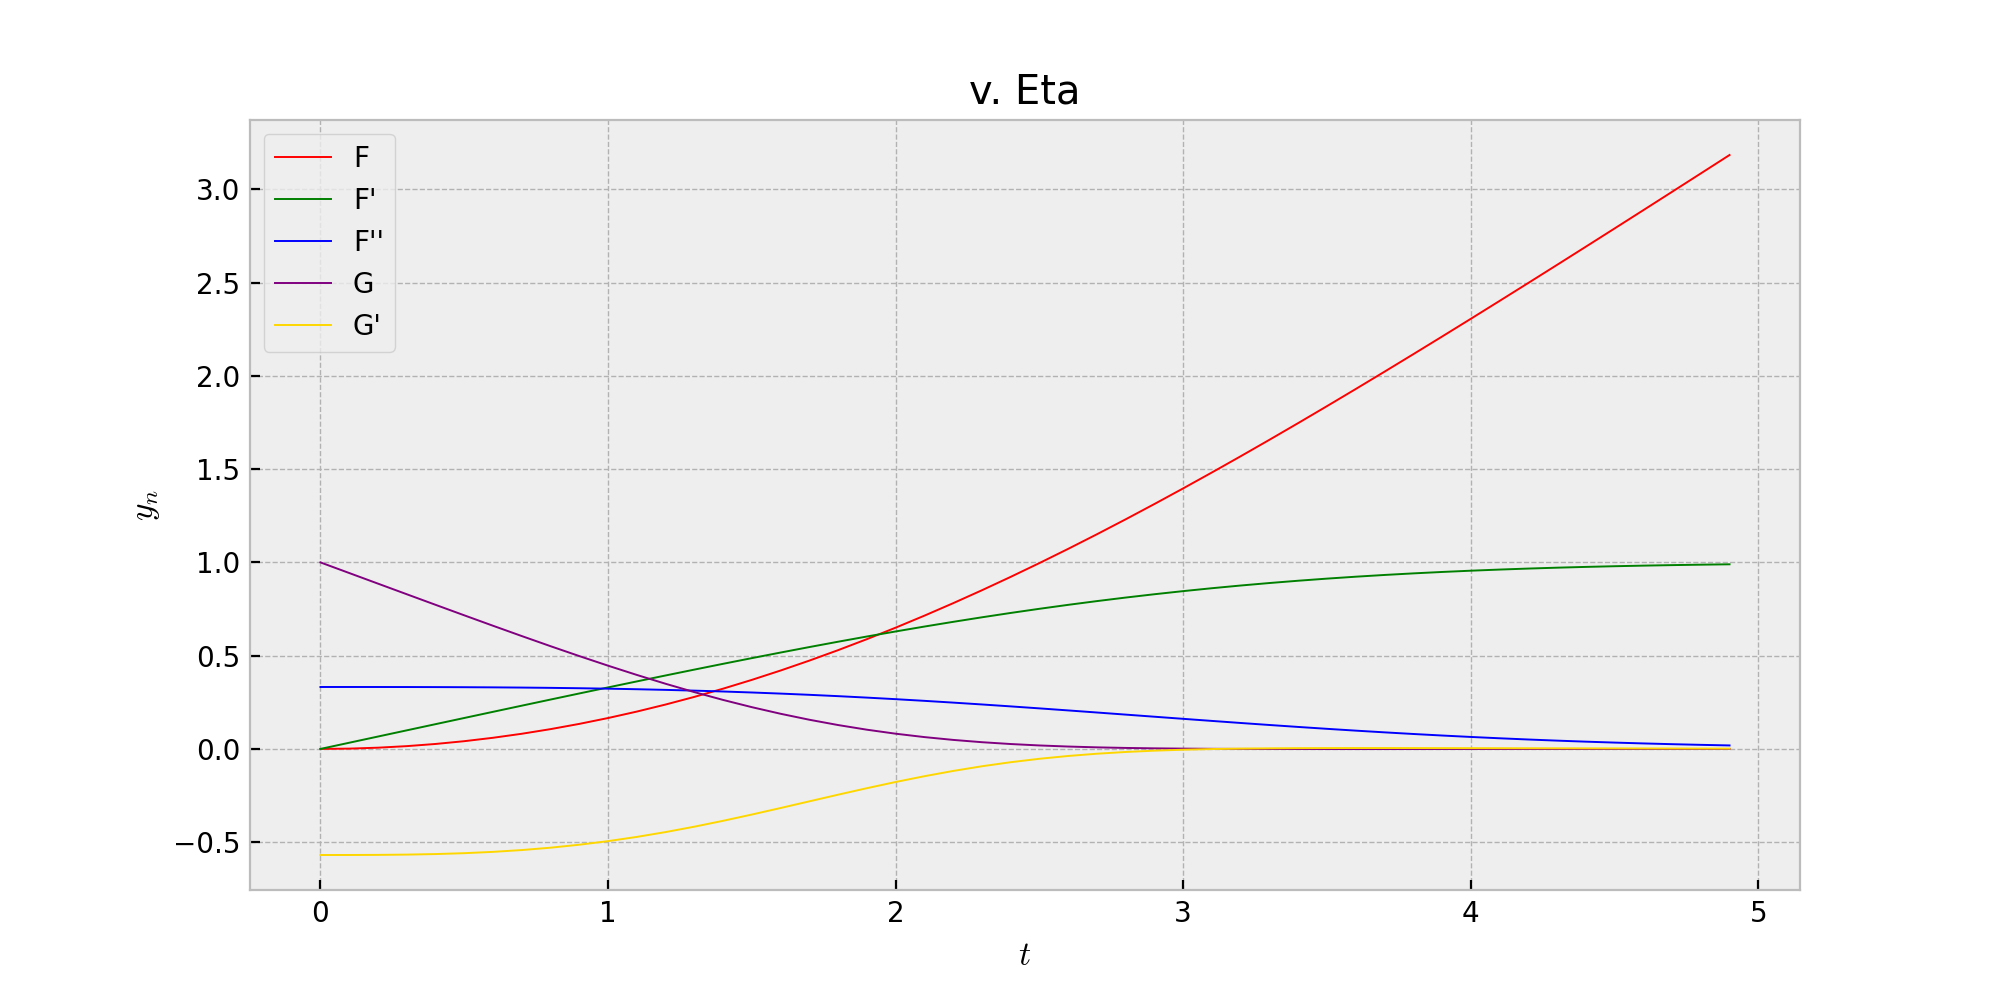

In [6]:
y1 = 0
y2 = 0
y3 = bisect(0.5,guess_to_residual,RK4)[2]
y4 = 1
y5 = bisect(-2,guess_to_residual_G,RK4_temp)[2]
       
rk4_data = np.zeros((n,5))
rk4_data[0,0] = y1
rk4_data[0,1] = y2
rk4_data[0,2] = y3
rk4_data[0,3] = y4
rk4_data[0,4] = y5

for i in range(n-1): 
        rk4_data[i+1,:] = RK4_temp(vector_t[i], rk4_data[i,0], rk4_data[i,1], rk4_data[i,2], rk4_data[i,3], rk4_data[i,4],  dt)
    
plt.figure(figsize=(10,5))
plt.title('v. Eta')
plt.ylabel('$y_n$')
plt.xlabel('$t$')

plt.plot(vector_t[:int(n*(0.5))], rk4_data[:int(n*(0.5)),0], color='red', label="F", linewidth='0.7')
plt.plot(vector_t[:int(n*(0.5))], rk4_data[:int(n*(0.5)),1], color='green', label="F'", linewidth='0.7')
plt.plot(vector_t[:int(n*(0.5))], rk4_data[:int(n*(0.5)),2], color='blue', label="F''", linewidth='0.7')
plt.plot(vector_t[:int(n*(0.5))], rk4_data[:int(n*(0.5)),3], color='purple', label="G", linewidth='0.7')
plt.plot(vector_t[:int(n*(0.5))], rk4_data[:int(n*(0.5)),4], color='gold', label="G'", linewidth='0.7')
plt.legend()
plt.show()

#### Showing a table
This is a table of the values for question ---

In [7]:
import pandas as pd

df = pd.DataFrame(rk4_data,columns=['F',"F'","F''",'G',"G'"])
df['Eta'] = np.arange(0,10,.1)
print(df)

           F        F'           F''             G            G'  Eta
0   0.000000  0.000000  3.320573e-01  1.000000e+00 -5.687038e-01  0.0
1   0.001660  0.033206  3.320482e-01  9.431294e-01 -5.686251e-01  0.1
2   0.006641  0.066408  3.319838e-01  8.862644e-01 -5.680743e-01  0.2
3   0.014941  0.099599  3.318094e-01  8.294493e-01 -5.665808e-01  0.3
4   0.026560  0.132764  3.314699e-01  7.727759e-01 -5.636799e-01  0.4
..       ...       ...           ...           ...           ...  ...
95  7.779212  1.000000  6.292236e-08 -5.206295e-10  1.296185e-08  9.5
96  7.879212  1.000000  4.254435e-08 -3.088388e-10  8.859691e-09  9.6
97  7.979212  1.000000  2.862270e-08 -1.643308e-10  6.024650e-09  9.7
98  8.079212  1.000000  1.916070e-08 -6.623993e-11  4.075762e-09  9.8
99  8.179212  1.000000  1.276274e-08 -1.602013e-16  2.743163e-09  9.9

[100 rows x 6 columns]


<IPython.core.display.Javascript object>


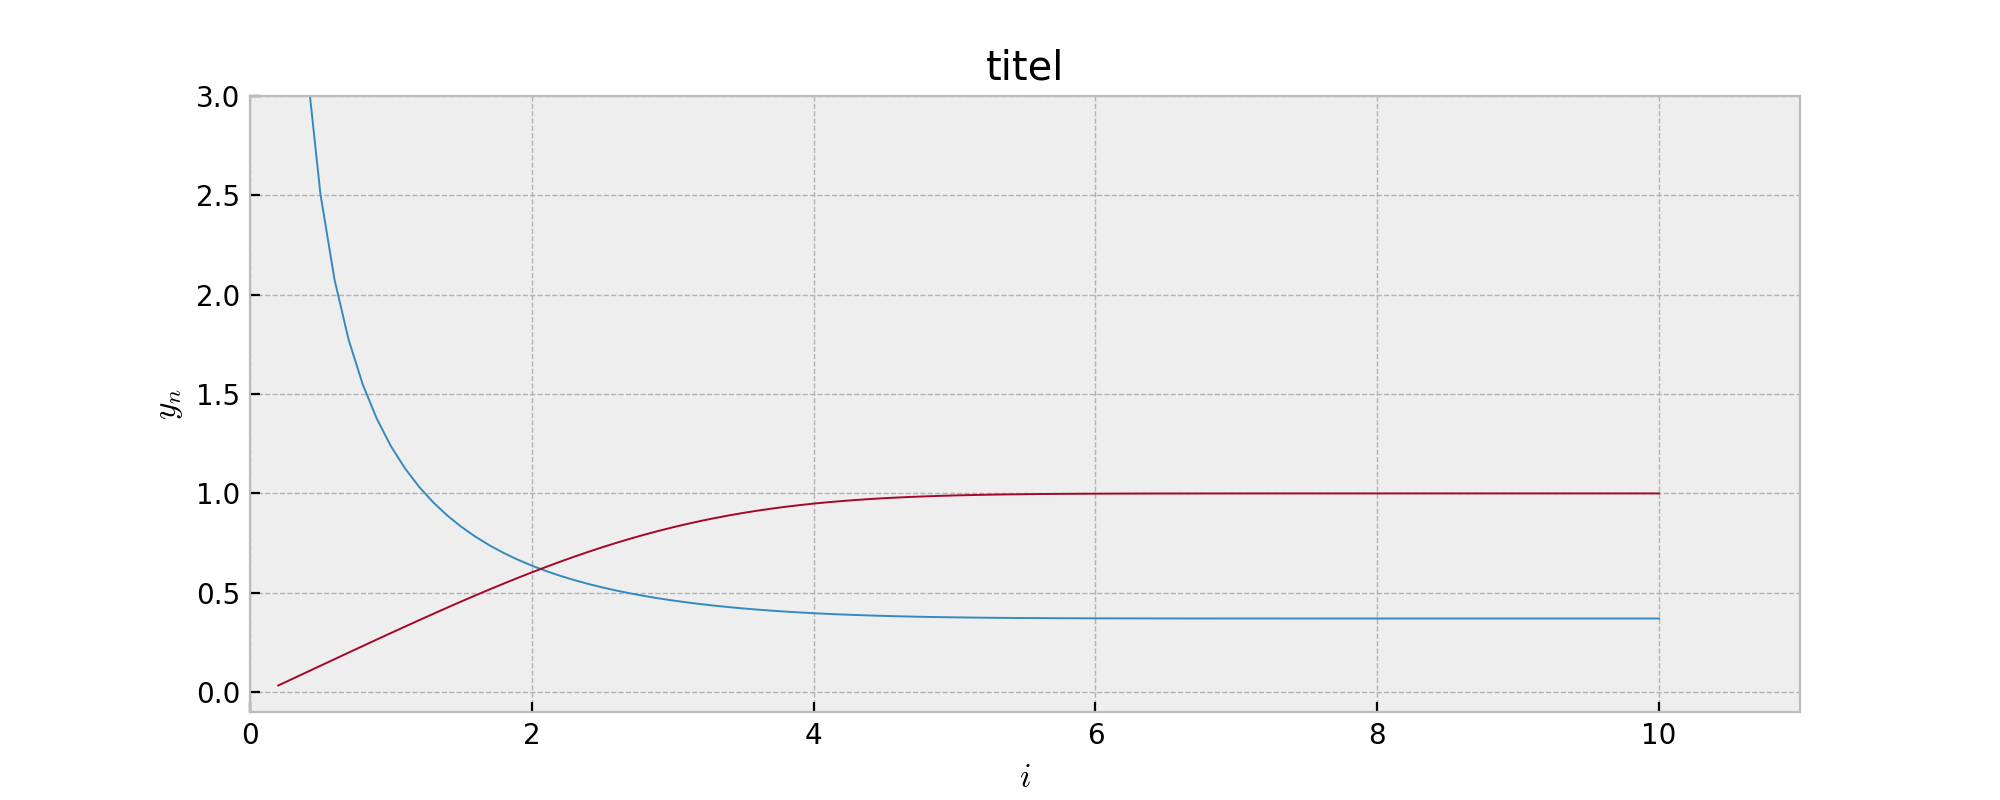

In [8]:
#A (1/2) * (eta*F'(eta) - F(eta)^(-1/2)
#B -> F'(eta)

eta = np.arange(0.1,10.1,.1)

A_vals = (1/2)*(np.array(eta[1:])*np.array(df["F'"][1:]) - np.array(df['F'][1:]))**(-1/2)
B_vals = np.array(df["F'"][1:])
plt.figure(figsize=(10,4))
plt.axis([0, 11, -0.1, 3])
plt.title('titel')
plt.ylabel('$y_n$')
plt.xlabel('$i$')
plt.plot(eta[1:], A_vals,linewidth='0.7')
plt.plot(eta[1:], B_vals,linewidth='0.7')

<IPython.core.display.Javascript object>


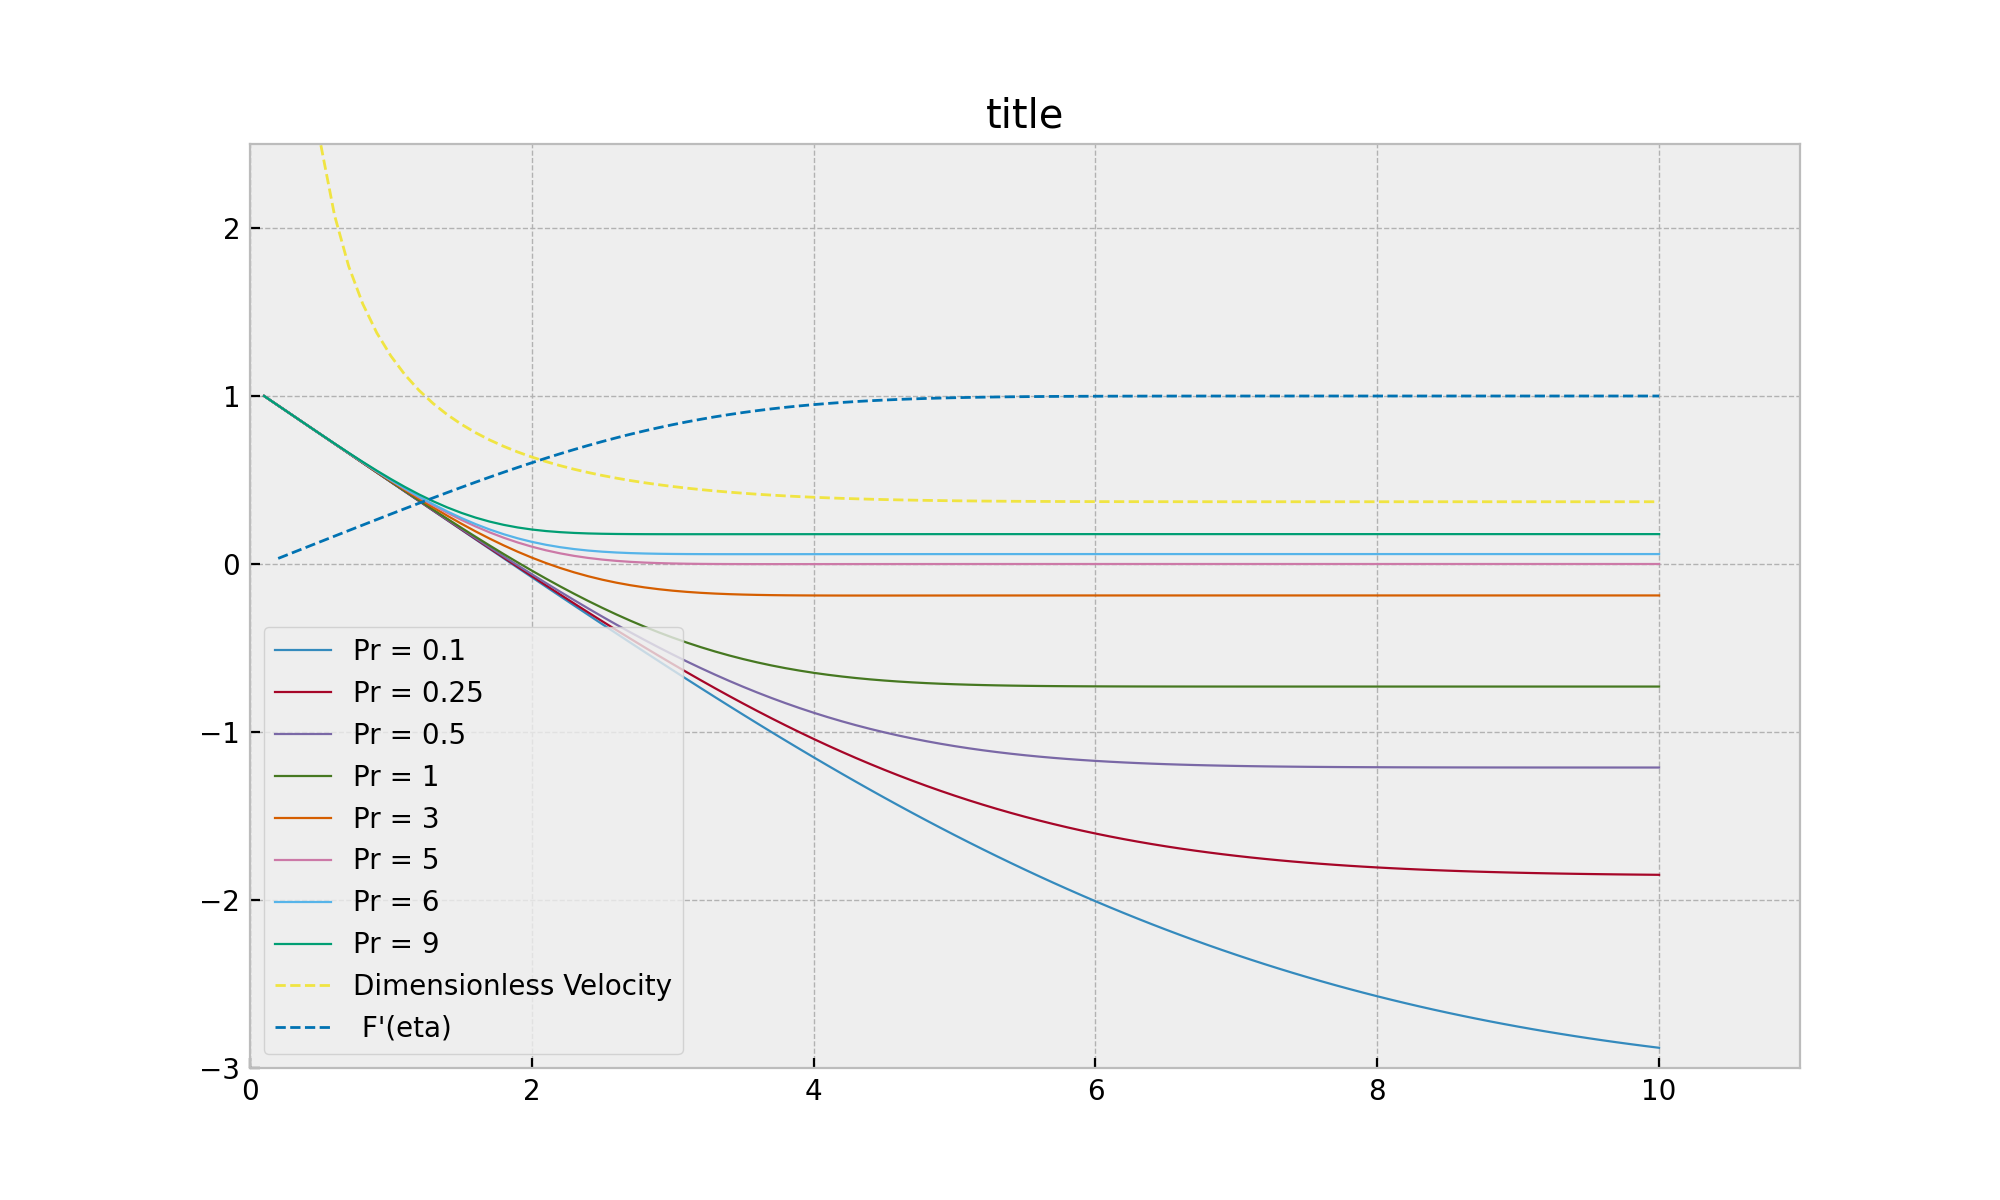

In [9]:
pr_vals = [0.1,.25,.5,1,3,5,6,9]
plt.figure(figsize=(10,6))
plt.axis([0, 11, -3, 2.5])
plt.title("title")
for pr in pr_vals:
    for i in range(n-1): 
        rk4_data[i+1,:] = RK4_temp(vector_t[i], rk4_data[i,0], rk4_data[i,1], rk4_data[i,2], rk4_data[i,3], rk4_data[i,4],  dt, pr)
    plt.plot(eta, rk4_data[:,3], label=f'Pr = {pr}', linewidth='0.8')
    
plt.plot(eta[1:], A_vals[:], label='Dimensionless Velocity', linewidth='1', linestyle='--')
plt.plot(eta[1:], B_vals[:], label=" F'(eta)", linewidth='1', linestyle='--')
plt.legend()

<IPython.core.display.Javascript object>


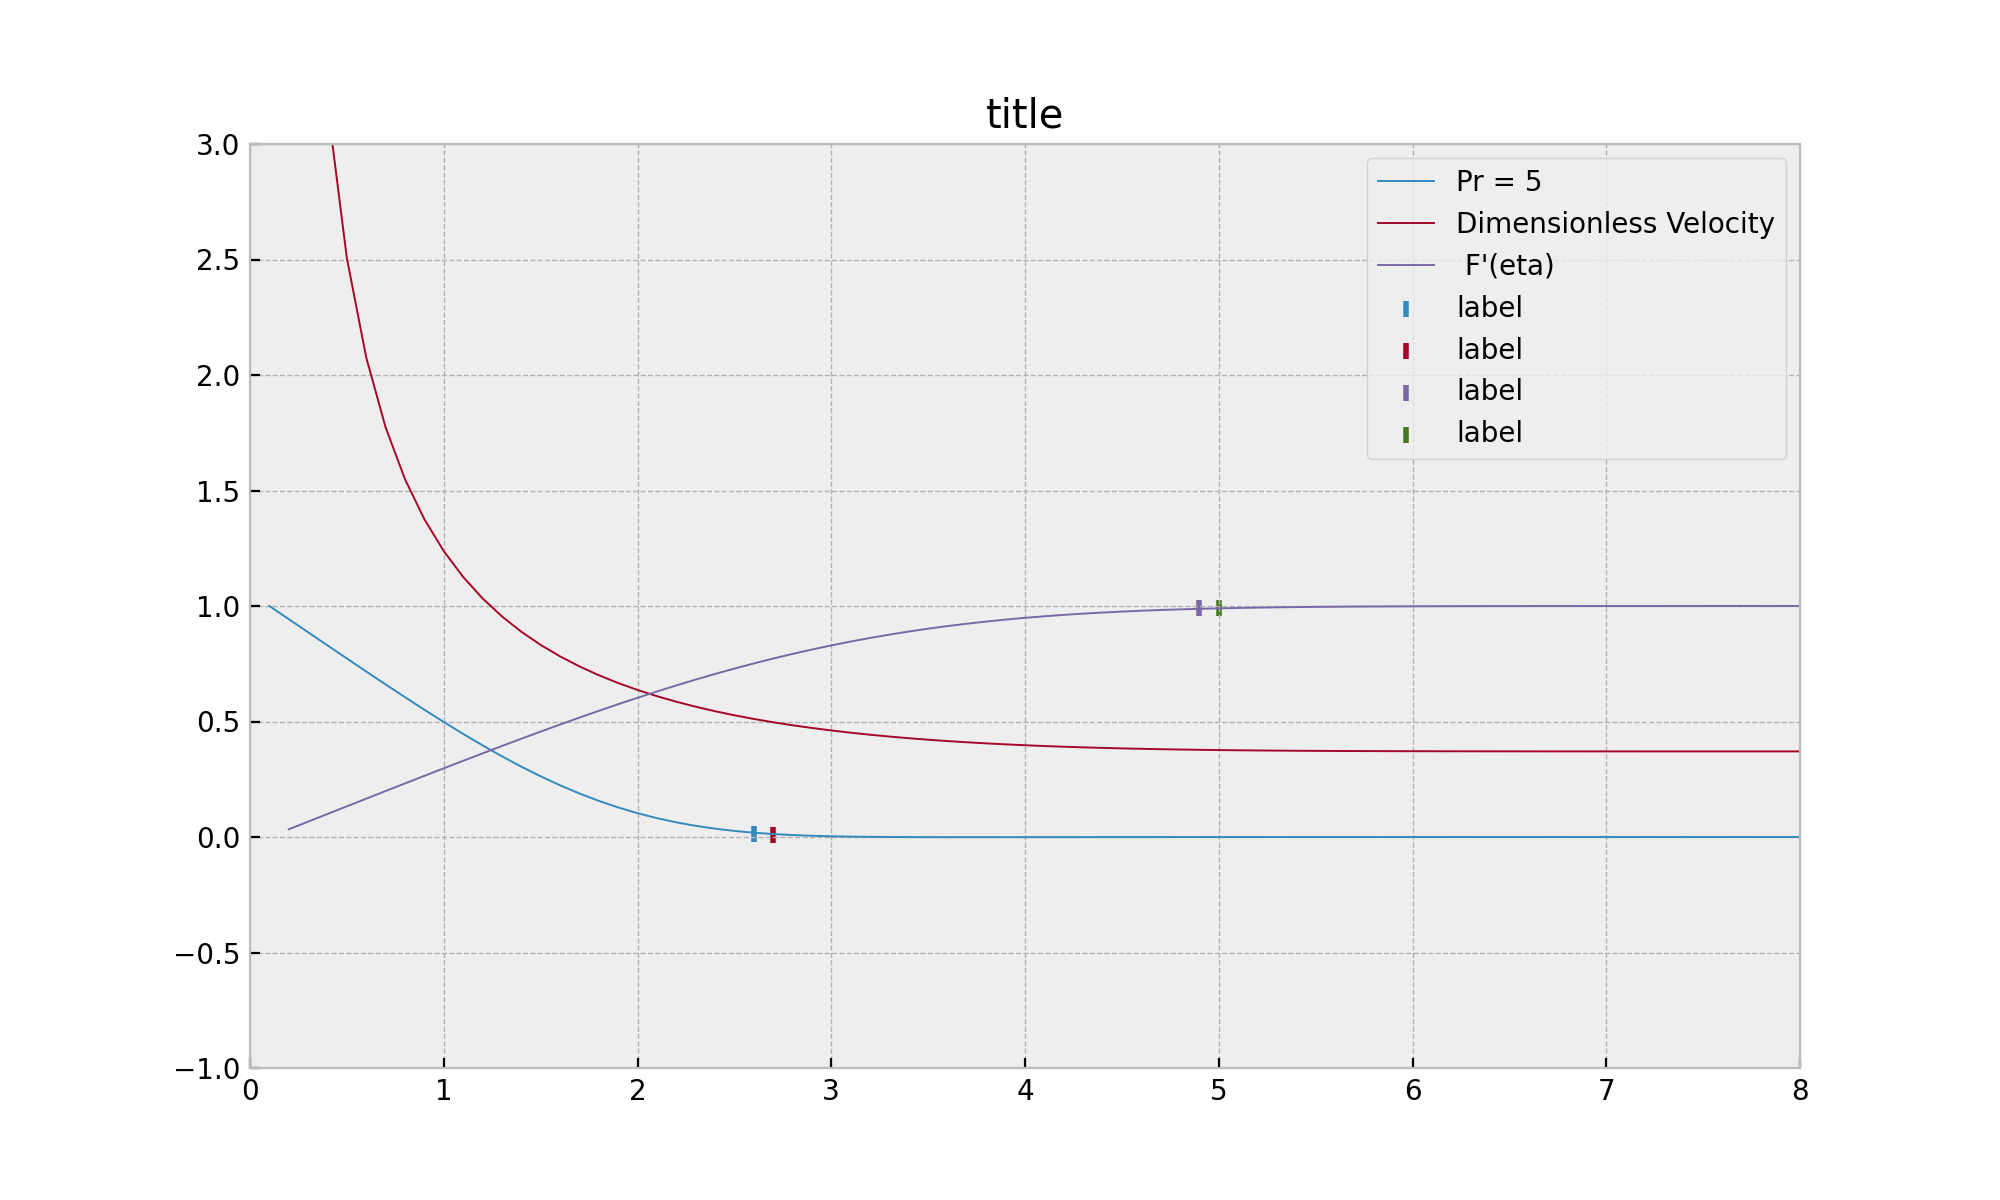

In [10]:
def find_eta_t(bound,df):
    for i in range(len(df['G'])):
        if df['G'][i] <= bound:
            lower_eta_t = np.array([df['Eta'][i-1],df['G'][i-1]])
            upper_eta_t = np.array([df['Eta'][i],df['G'][i]])
            return lower_eta_t, upper_eta_t

def find_eta_m(bound,df):
    for i in range(len(df["F'"])):
        if df["F'"][i] >= bound:
            lower_eta_m = np.array([df['Eta'][i-1],df["F'"][i-1]])
            upper_eta_m = np.array([df['Eta'][i],df["F'"][i]])
            return lower_eta_m, upper_eta_m

pr_vals = [5]
plt.figure(figsize=(10,6))
plt.axis([0, 8, -1, 3])
plt.title("title")
for pr in pr_vals:
    for i in range(n-1): 
        rk4_data[i+1,:] = RK4_temp(vector_t[i], rk4_data[i,0], rk4_data[i,1], rk4_data[i,2], rk4_data[i,3], rk4_data[i,4],  dt, pr)
    plt.plot(eta,rk4_data[:,3],label = f'Pr = {pr}', linewidth='0.7')
plt.plot(eta[1:], A_vals, label='Dimensionless Velocity', linewidth='0.7')
plt.plot(eta[1:], B_vals, label=" F'(eta)", linewidth='0.7')
plt.scatter(find_eta_t(0.01,df)[0][0], find_eta_t(0.01,df)[0][1], label='label', marker='|')
plt.scatter(find_eta_t(0.01,df)[1][0], find_eta_t(0.01,df)[1][1], label='label',marker='|')
plt.scatter(find_eta_m(0.99,df)[0][0], find_eta_m(0.99,df)[0][1], label='label', marker='|')
plt.scatter(find_eta_m(0.99,df)[1][0], find_eta_m(0.99,df)[1][1], label='label',marker='|')
plt.legend()